In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, sys
from collections import defaultdict

from scipy.optimize import curve_fit

import glob
from matplotlib.backends import backend_pdf

import warnings
warnings.filterwarnings('ignore')

import sqlite3

def readSqlitedb(database="/cvmfs/icarus.opensciencegrid.org/products/icarus/icarus_data/v09_62_00/icarus_data/database/ChannelMapICARUS.db", table="pmt_placements"):

    # Read sqlite query results into a pandas DataFrame
    con = sqlite3.connect(database)
    df = pd.read_sql_query("SELECT * from {}".format(table), con)

    con.close()

    return df


# TODO: NOT SURE OF THE CORRECT VOLTAGE-CHANNEL ASSOCIATION <<---
def load_hv(filename, voltages):

    """
    Makes a dictionary with key the channelId and as value the voltage set
    """
    geo = readSqlitedb()

    for line in open(filename, "r"):

        buff = line.split(",")

        if "{icarus" in buff[0]:

            try: 
                pmtid = int(buff[6])
                channel_id = geo[geo.pmt_id==pmtid].channel_id.values[0]
                value = int( buff[7] )
                          
                voltages[channel_id].append(value)
            
            except ValueError:
                continue 
    return



def load_files(runhvdb, path="../calibrationdb/"):
    
    files = [ glob.glob(path+'backgroundphotons_run%d_*.csv'%run)[0] for run in runhvdb.keys() ]
    df = pd.concat( [pd.read_csv(path+file, sep=',') for file in files ] )
    df=df.groupby("pmt").agg({'q':list, 'eq':list}).reset_index()
    
    return df



def get_list_for_ch( ch, df, voltages):
    
    bkg_q = np.array(df[df.pmt==ch].q.values[0])
    bkg_eq = np.array(df[df.pmt==ch].q.values[0])*0.02
    
    #filters for null or 0 values
    g = bkg_q[np.where( bkg_q > 0.05 )]
    eg = bkg_eq[np.where( bkg_q > 0.05 )]
    v = np.array(voltages[ch])[np.where( bkg_q > 0.05 )]
    
    return v, g, eg

def poly( v, a, k ):
    return a*np.power(v,k)

def ipoly( g, a, ea, k, ek ): 
    
    v0 = np.power(g/a, 1./k)
    
    dvda = -(1./k)*np.power(0.5, 1./k)*np.power(1./a, 1./(k+1))
    dvdk = -(1./k**2)*np.power(0.5, 1./k)*np.power( (1./a)*(np.log(1./a)-np.log(0.5)), 1./k )
    
    ev0 = np.sqrt( (dvda*ea)**2 + (dvdk*ek)**2 )
    
    return v0, ev0

def dofit( data_x, data_y, error_y, g_target=0.5 ):
    """
    Args: 
        g_target: target gain in units of 10^7
    Returns: 
        ..
        ..
    """
    
    btrials=[5,6,7,7.5,8]
    trials=0
    b=btrials[0]
    
    params=[]
    pcov=[]
    
    repeatfit=True
    
    while repeatfit:
        try:
            #print("Try fit using b: %.2f" % b)
            params, pcov = curve_fit(poly, data_x, data_y, sigma=error_y, absolute_sigma=True, p0=[1e-13, b])
            repeatfit=False
        except:
            trials=trials+1
            if trials<len(btrials):
                b=btrials[trials]
                #print("Repeat fit using b: %.2f" % b)
            else: 
                #print("Finished the amount of trials available for fit")
                raise 
        else: 
            repeatfit=False
            
            
    stderr = np.sqrt(np.diag(pcov))
    
    xint = np.linspace( np.min(data_x)-10, np.max(data_x)+10, 1000 )
    yint = poly(xint, params[0], params[1])
    
    vnom, evnom= ipoly( g_target, params[0], stderr[0] , params[1], stderr[1] )
    
    #print(params, np.sqrt(np.diag(pcov)), vnom, evnom)
    
    return params, np.sqrt(np.diag(pcov)), xint, yint, vnom, evnom



def plotone( PMT, bb, vv ):
    fig, ax = plt.subplots(1,1, figsize=(10, 4.8))

    v, g, eg = get_list_for_ch(PMT, bb, vv)

    kargs={'marker':'o', 'lw':0.0, 'elinewidth':2.0}

    out=ax.errorbar( x=v, y=g, yerr=eg, label="Channel ID: %d" % PMT, **kargs )
    res = dofit( v, g, eg )

    p=res[0]
    ep=res[1]
    xint=res[2]
    yint=res[3]
    vnom=res[4]
    evnom=res[5] 

    label= "FIT $a \cdot V^k$: \n"
    label+="a: %.2e $\pm$ %3.e\n" % ( p[0], ep[0] ) 
    label+="b: %.2f $\pm$ %.3f\n" % ( p[1], ep[1] )
    label+='V($5 \cdot 10^6$)= %d $\pm$ %d' % ( vnom, evnom )

    ax.plot(xint, yint, color=out[0].get_color(), lw=1.0, label=label)

    ax.set_ylabel("Gain [$10^7$ electrons]")
    ax.set_xlabel("Voltage [V]")
    ax.legend(fontsize=16)
    
    fig.tight_layout()

    return fig
    

def loaddata(runhvdb):

    bkg = load_files(runhvdb, path="../analyze_runs/calibrationdb/")

    voltages = defaultdict(list)
    for run, suffix in runhvdb.items(): 
        load_hv( "../hv_files/Sy4527channels_Dec2022_{}.sub".format(suffix), voltages )
    return voltages, bkg


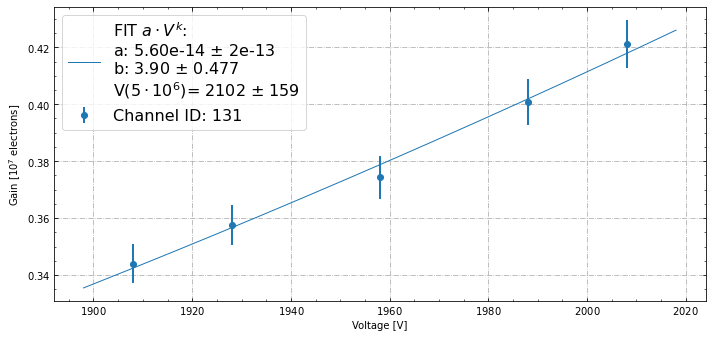

In [2]:
runhvdb = { 9230:"m50", 9229:"m30", 9226: "nominal", 9227:"p50", 9228:"p100" }
voltages, bkg = loaddata(runhvdb)
plotone( 131, bkg, voltages ) 

plt.show()

In [8]:
# SAVE MANY TO FILE
geo = readSqlitedb()

runhvdb = { 9230:"m50", 9229:"m30", 9226: "nominal", 9227:"p50", 9228:"p100" }
voltages, bkg = loaddata(runhvdb)

new_voltages = {}

pdf = backend_pdf.PdfPages("calibration_Dec2022.pdf")

for channel_id in range(0, 360):
    
    pmt_id = geo[geo.channel_id==channel_id].pmt_id.values[0]
    
    # We skip some ch known problemaic
    ## 5  21  59  71 103 127 131 139 161 190 215 248 350 : have nominal at 0 (switched-off)
    ## ... 
    ## ...
    if channel_id in [ 5, 21, 59, 71, 103, 127, 131, 139, 161, 190, 215, 248, 350 ]:
        print("Put to 0 the voltage on channel_id: {} , pmt_id: {}".format(channel_id, pmt_id))    
        new_voltages[pmt_id] = 0
        continue
            
    # Define the plot
    fig, ax = plt.subplots(1,1, figsize=(10, 4.8))
    kargs={'marker':'o', 'lw':0.0, 'elinewidth':2.0}

    #Fetch data
    v, g, eg = get_list_for_ch(channel_id, bkg, voltages)
           
    try:
        out=ax.errorbar( x=v, y=g, yerr=eg, label=("Channel ID: %d" % channel_id), **kargs )
    
        try:
            res = dofit( v, g, eg )
            
            p=res[0]
            ep=res[1]
            xint=res[2]
            yint=res[3]
            vnom=res[4]
            evnom=res[5] 

            label= "FIT $a \cdot V^k$: \n"
            label+="a: %.2e $\pm$ %3.e\n" % ( p[0], ep[0] ) 
            label+="b: %.2f $\pm$ %.3f\n" % ( p[1], ep[1] )
            label+='V($5 \cdot 10^6$)= %d $\pm$ %d' % ( vnom, evnom )
            
            ax.plot(xint, yint, color=out[0].get_color(), lw=1.0, label=label)
            
            new_voltages[pmt_id] = int(vnom)
            
            if vnom > v[-1]:
                print("V {} is larger than {}. Interpolated value for channel_id: {} , pmt_id: {}".format(vnom, v[-1], channel_id, pmt_id))  
            if vnom < v[0]:
                print("V {} is smaller than {}. Interpolated value for channel_id: {} , pmt_id: {}".format(vnom, v[0], channel_id, pmt_id)) 
        
            if vnom > 2000: 
                print("Has V larger than 2000V channel_id: {} , pmt_id: {}. Set it to 0 instead".format(channel_id, pmt_id))      
                new_voltages[pmt_id] = 0
        
        except:
            print("Impossible to fit channel_id: {} , pmt_id: {}".format(channel_id, pmt_id))   
    except:
        print("Impossible to plot channel_id: {} , pmt_id: {}".format(channel_id, pmt_id)) 
    

    ax.set_ylabel("Gain [$10^7$ electrons]")
    ax.set_xlabel("Voltage [V]")
    ax.legend(fontsize=16)
    
    fig.tight_layout()
    pdf.savefig( fig )
    
    plt.close()


pdf.close()

Put to 0 the voltage on channel_id: 2 , pmt_id: 353
V 1854.1365326136938 is smaller than 1932. Interpolated value for channel_id: 23 , pmt_id: 334
Put to 0 the voltage on channel_id: 29 , pmt_id: 340
Put to 0 the voltage on channel_id: 51 , pmt_id: 302
Put to 0 the voltage on channel_id: 58 , pmt_id: 309
V 1720.8160544586094 is smaller than 1735. Interpolated value for channel_id: 62 , pmt_id: 293
Put to 0 the voltage on channel_id: 79 , pmt_id: 290
Impossible to fit channel_id: 90 , pmt_id: 269
Put to 0 the voltage on channel_id: 106 , pmt_id: 254
V 2024.274598479845 is larger than 1948. Interpolated value for channel_id: 124 , pmt_id: 238
Has V larger than 2000V channel_id: 124 , pmt_id: 238. Set it to 0 instead
V 2102.6297576488905 is larger than 2008. Interpolated value for channel_id: 131 , pmt_id: 230
Has V larger than 2000V channel_id: 131 , pmt_id: 230. Set it to 0 instead
Put to 0 the voltage on channel_id: 139 , pmt_id: 222
V 1992.3776778697354 is larger than 1938. Interpolat

In [14]:
# create the HV file

def writeHVFile( oldfilename, newfilename, newvoltages, capvalues=False ):

    nfp = open(newfilename, "w")

    for line in open(oldfilename , "r"):

        buff = line.split(",")

        if '{icarus' in buff[0]:

            try:
                pmtID = int(buff[6])
            except ValueError:
                print("Warning: invalid PMT id for {}".format(buff[6]))
                line = ",".join(buff)
                nfp.write(line)
                continue

            oldvalue = int(buff[7])
            value=oldvalue
            
            #If a new value exists override it
            try:
                value = newvoltages[pmtID]
            except:
                print( "WARNING: No voltage changes for PMT {}".format(pmtID) )
                #continue
                

            hwarning = 20
            hcaring = 5

            # Cap values over 2000 V
            if value > 2000:
                print( "WARNING: Capped voltage to 2000V for PMT {}".format(pmtID) )
                value=2000
            #else:
                #print( "Replacing {}V with {}V for PMT {}".format(oldvalue, value, pmtID) )

            # here we write the new line to file
            newline = buff
    
            newline[7] = " " + str( value ) #Main nominal value
            newline[9] = " " + str( value+hwarning )
            newline[10] = " " + str( value+hcaring )
            newline[11] = " " + str( value-hcaring )
            newline[12] = " " + str( value-hwarning )+" }\n"

            line =  ",".join(newline)
            nfp.write(line)

        else:
            line = ",".join(buff)
            nfp.write(line)

    print( "Create new file {}".format(newfilename) )
    nfp.close()

    return


#vv = [new_voltages[key] for key in new_voltages.keys()]
#print( np.mean(vv), np.std(vv), np.min(vv), np.max(vv) )
#plt.hist( vv, bins=20, range=(1300, 2200) )  
#plt.show()

#Put in manually some channel 
#new_voltages[90] = 1690
#new_voltages[263] = 1600

writeHVFile("../hv_files/Sy4527channels_Dec2022_nominal.sub", "../hv_files/Sy4527channels_Dec2022_calibrated.sub", new_voltages, True)

Create new file ../hvdb/Sy4527channels_22122021_calibrated.sub


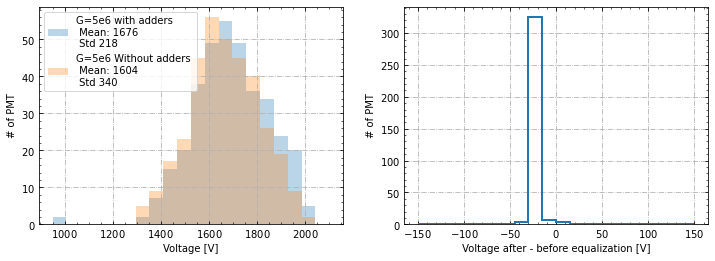

In [12]:
old_hv_dict = defaultdict(list)
new_hv_dict = defaultdict(list)
load_hv( "../hv_files/Sy4527channels_Dec2022_nominal.sub", old_hv_dict )
load_hv( "../hv_files/Sy4527channels_Dec2022_calibrated.sub", new_hv_dict )

old_hv=np.array([ ii[1][0] for ii in old_hv_dict.items() ])
new_hv=np.array([ ii[1][0] for ii in new_hv_dict.items() ])

fig, ax = plt.subplots(1,2, figsize=(12, 4))

ax[0].hist( old_hv, bins=20, range=(950, 2100), alpha=0.3, label="G=5e6 with adders \n Mean: %d \n Std %d" %  ( np.mean(old_hv), np.std(old_hv) ) )
ax[0].hist( new_hv, bins=20, range=(950, 2100), alpha=0.3, label="G=5e6 Without adders \n Mean: %d \n Std %d" %  ( np.mean(new_hv), np.std(new_hv) ) )

ax[0].set_ylabel("# of PMT")
ax[0].set_xlabel("Voltage [V]")

ax[0].legend()

ax[1].hist( new_hv-old_hv, bins=20, range=(-150, 150), label="G=5e6", histtype='step', lw=2.0 )
ax[1].set_ylabel("# of PMT")
ax[1].set_xlabel(" Voltage after - before equalization [V] " )

#plt.legend()
plt.savefig("voltage_distribution.pdf")

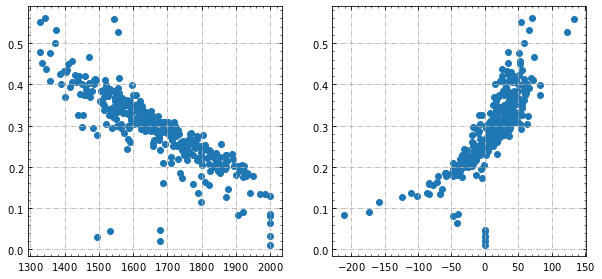

In [23]:
runhvdb = { 9230:"m50", 9229:"m30", 9226: "nominal", 9227:"p50", 9228:"p100" }
voltages, bkg = loaddata(runhvdb)

valid_pmts = [ pmt for pmt in range(0, 360) if pmt not in [ 51, 58, 139, 212, 106, 90, 79 ] ]  
gains_array = [  get_list_for_ch(pmt, bkg, voltages)[1] for pmt in range(0, 360) if pmt not in [ 51, 58, 139, 212, 106, 90, 79 ] ]
gains_diff = [ np.max(val)-np.min(val) for val in gains_array ]
new_volt_array = [  new_hv_dict.get(pmt)[0] for pmt in range(0, 360) if pmt not in [ 51, 58, 139, 212, 106, 90, 79 ] ]
delta_volt_array = [  old_hv_dict.get(pmt)[0]-new_hv_dict.get(pmt)[0] for pmt in range(0, 360) if pmt not in [ 51, 58, 139, 212, 106, 90, 79 ] ]

fig, ax = plt.subplots(1,2, figsize=(10, 4.6))

ax[0].scatter( maxvolt_array, gains_diff )
ax[1].scatter( delta_volt_array, gains_diff )